# Seminar Paper: High-frequency Periodicity in Cryptocurrency Trading

## Data Preparation

In [1]:
import pandas as pd, numpy as np, os
from datetime import datetime as dt
import calendar
import statsmodels.api as sm, matplotlib.pyplot as plt, seaborn as sns, scipy.stats as st
from sklearn import linear_model

### Folder Structure

In [2]:
path_to_files = "BTCUSD Datasets/"
path_to_input = path_to_files +"1. Input/"
folders = ["2. Output", "3. Graphs", "4. Tables"]
years = ['2018','2019','2020','2021','2022']

#Creating folder structure, where initial folder is given with 1.Input and respective stata files
for i in folders:
    try:
        os.mkdir(path_to_files + i)
    except (FileExistsError):
        continue
        
#Declaration of useful variables
datasets = ['coinbase_trades_btc_usd_2018.dta','coinbase_trades_btc_usd_2019.dta', 'coinbase_trades_btc_usd_2020.dta', 'coinbase_trades_btc_usd_2021.dta', 'coinbase_trades_btc_usd_2022.dta']
additive = ['size', 'log_ret','d_transaction']
nadditive = ['timedelta', 'price', 'per_change']

### Merging Datasets

In [ ]:
combined = pd.DataFrame()
for i in datasets:
    if combined.empty:
        combined = pd.read_stata(path_to_input + i, columns=['time_seconds','price','size'])
    try:
        dataset = pd.read_stata(path_to_input + i, columns=['time_seconds','price','size'])
        combined = pd.concat([combined,dataset], ignore_index= True)
        #Save as .dta in 2. Output
        combined.to_stata(path_to_files + "2. Output/combined_raw_data.dta")
    except (FileExistsError):
        continue
        

In [3]:
# Test sample
dataset = pd.read_stata(path_to_files + '1. Input/coinbase_trades_btc_usd_' + str(2018) + '.dta', columns=['time_seconds','price','size'])
dataset = dataset.sort_values(by = 'time_seconds', ascending=[True])

In [16]:
start = 1000*dataset['time_seconds'].min()
end = 1000*dataset['time_seconds'].max()
hours = pd.date_range(start = start, end = end, freq = 'H')

In [17]:
hours

DatetimeIndex(['1970-01-01 00:25:14.764801115'], dtype='datetime64[ns]', freq='H')

### Calculating target variables

In [5]:
# generating dataset with equidistant timestamps with freq=1s for further high-frequency analysis.
#We make the explicit assumption that if no trade has occured at given timestamp the marketprice remains the same 


#### Useful time methods

In [70]:
def getyear(time_series):
    if 'year' in dataset.columns:
        pass
    else:
        dataset['year']=time_series.dt.isocalendar().year

def getweek(time_series):
    if 'week' in dataset.columns:
        pass
    else:
        dataset['week']=time_series.dt.isocalendar().week

def getweekday(time_series):
    if 'weekday' in dataset.columns:
        pass
    else:
        dataset['weekday'] = time_series.dt.weekday

def getday(time_series):
    if 'day' in dataset.columns:
        pass
    else:
        dataset['day']=time_series.dt.day

def gethour(time_series):
    if 'hour' in dataset.columns:
        pass
    else:
        dataset['hour']=time_series.dt.hour

def getminute(time_series):
    if 'minute' in dataset.columns:
        pass
    else:
        dataset['minute']=time_series.dt.minute

def getsecond(time_series):
    if 'second' in dataset.columns:
        pass
    else:
        dataset['second']=time_series.dt.second

def getmillisecond(time_series):
    if 'millisecond' in dataset.columns:
        pass
    else:
        dataset['millisecond']=round(time_series.dt.microsecond/1000, 0)

## Descriptive Content

In [71]:
import statsmodels.api as sm, matplotlib.pyplot as plt, seaborn as sns, scipy.stats as st

#### Formating of Charts

In [72]:
#File path
path_to_graphics = path_to_files+"3. Graphs/"

#Chart Characteristics
width = 30
height = 10
subplot_title = 25
subplot_label = 20

In [ ]:
dataset = pd.read_stata(path_to_files + "2. Output/combined_raw_data.dta",).reset_index(drop=True)

### Time-Series of returns, volatility, and volume (amount of trades and size in btc / Dollar) (years as lines)

#### Price Movement over the years - average price per week

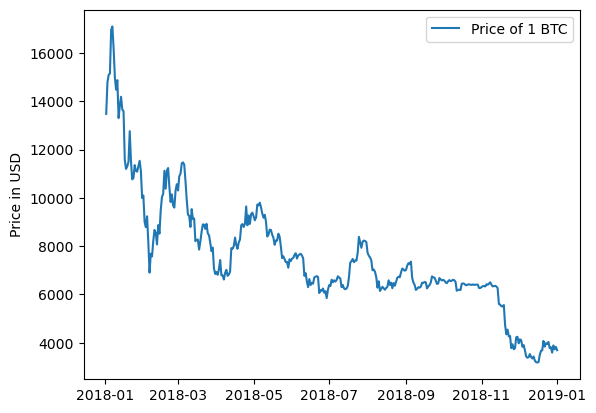

In [54]:
# Price Movement over timeframe (2018-2022)
time_dimensions = ['year', 'week', 'day']

# Generate relevant time parameters
getyear(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getweek(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getday(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))

data_plot = dataset.sort_values(by='time_seconds', ascending=[True]).drop_duplicates(subset = time_dimensions, keep = 'last').reset_index(drop=True)

# Plot
plt.plot (pd.to_datetime(data_plot['time_seconds']*1000, unit ='ms'), data_plot['price'], label = 'Price of 1 BTC')
plt.ylabel('Price in USD')
plt.legend()
plt.show()

# Plot Content - Unique
# Show and Save as Output
#plt.savefig(path_to_store + "Trend over weekdays.png", bbox_inches = 'tight')

####  Volatility Movement over the years - annualized daily volatility

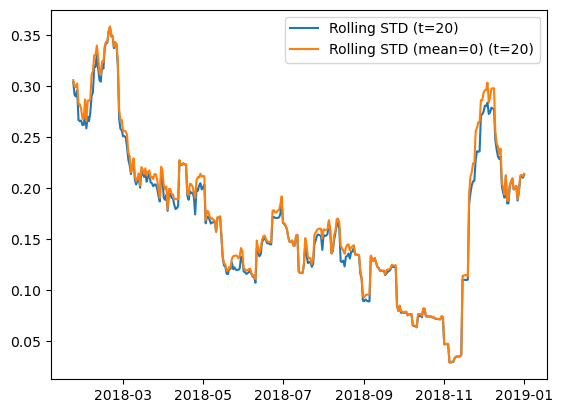

In [166]:
time_dimensions = ['year', 'week','day']
# Retrieve needed time variables
getyear(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getweek(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getday(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))

data_plot = dataset.sort_values(by='time_seconds', ascending=[True]).drop_duplicates(subset = time_dimensions, keep = 'last').reset_index(drop=True)
data_plot = data_plot.sort_values(by = 'time_seconds', ascending=[True])

# We calculate the std over a rolling time frame of t = 30 days with log returns calculated by taking the last transaction of a day
data_plot['daily_returns']= np.log(1+data_plot['price'].pct_change())

rolling_window = 20
# We calculate the std on a rolling basis with fixed window size and annualize it by assuming 365 trading days
data_plot['std'] = data_plot.daily_returns.rolling(rolling_window).std() * np.sqrt(365/rolling_window)
# Calculating the annualized daily std with the assumption that rolling mean is zero
data_plot['std_zero_mean'] = np.sqrt((data_plot['daily_returns'].apply(lambda x: (x)**2).rolling(rolling_window).sum())/(rolling_window-1))* np.sqrt(365/rolling_window)

# Plot
plt.plot (pd.to_datetime(data_plot['time_seconds']*1000, unit ='ms'), data_plot['std'], label = 'Rolling STD (t=20)')
plt.plot (pd.to_datetime(data_plot['time_seconds']*1000, unit ='ms'), data_plot['std_zero_mean'], label = 'Rolling STD (mean=0) (t=20)')

plt.legend()
plt.show()

#### Trade activity over the years - daily number of transactions

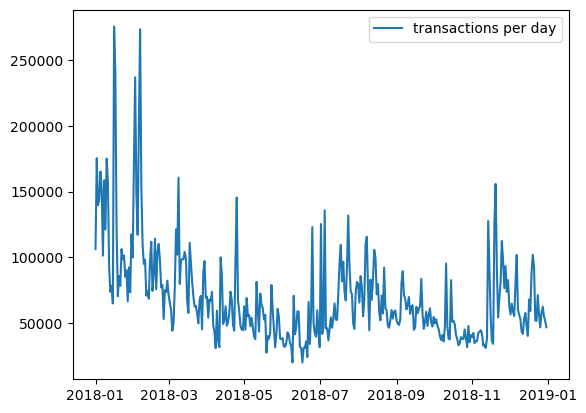

In [52]:
time_dimensions = ['year', 'week','day']
# Retrieve needed time variables
getyear(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getweek(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getday(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))

data_plot = dataset.filter(['time_seconds','year', 'week','day']).sort_values(by = 'time_seconds', ascending=True)
data_plot['transaction_count'] = 1
data_plot['transaction_count'] = data_plot.groupby(by=time_dimensions, axis=0)['transaction_count'].transform('count')
data_plot = data_plot.drop_duplicates(subset = time_dimensions).reset_index(drop=True)

# Plot
plt.plot (pd.to_datetime(data_plot['time_seconds']*1000, unit ='ms'), data_plot['transaction_count'], label = 'transactions per day')

plt.legend()
plt.show()

#### Trade activity over the years - daily size of trades in btc and USD

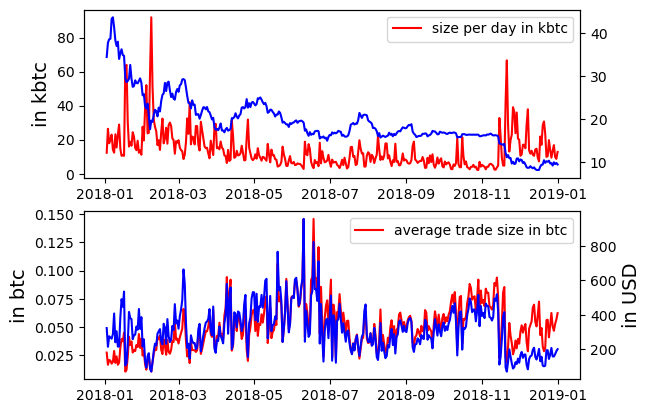

In [80]:
time_dimensions = ['year', 'week','day']
# Retrieve needed time variables
getyear(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getweek(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getday(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))

data_plot = dataset.filter(['time_seconds','year', 'week','day','price','size']).sort_values(by = 'time_seconds', ascending=True)
data_plot['size'] = data_plot.groupby(by=time_dimensions, axis=0)['size'].transform('sum')
data_plot['transaction_count'] = 1
data_plot['transaction_count'] = data_plot.groupby(by=time_dimensions, axis=0)['transaction_count'].transform('count')
data_plot = data_plot.drop_duplicates(subset = time_dimensions, keep='last').reset_index(drop=True)
data_plot['USD_size'] = data_plot.size * data_plot.price
data_plot['size_per_trade'] = data_plot.size / data_plot.transaction_count
data_plot['USD_size_per_trade'] = data_plot.USD_size / data_plot.transaction_count

# Plot
# create figure and axis objects with subplots()
fig,(ax, ax2) = plt.subplots(nrows=2)

# first plot - daily (USD) size of transactions
ax.plot(pd.to_datetime(data_plot['time_seconds']*1000, unit ='ms'), data_plot['size']/(10**3), label = 'size per day in kbtc', color="red")
ax1=ax.twinx()
# make a plot with different y-axis using second axis object
ax1.plot(pd.to_datetime(data_plot['time_seconds']*1000, unit ='ms'), data_plot['USD_size']/(10**6), label = 'size per day in mUSD',color="blue")
ax.set_ylabel("in kbtc", fontsize = 14)
ax3.set_ylabel('in mUSD', fontsize = 14)
ax.legend(['size per day in kbtc','size per day in mUSD'])

# second plot - daily average (USD) size per transaction
ax2.plot(pd.to_datetime(data_plot['time_seconds']*1000, unit ='ms'), data_plot['size_per_trade'], label = 'avg size per day in kbtc', color="red")
ax3=ax2.twinx()
# make a plot with different y-axis using second axis object
ax3.plot(pd.to_datetime(data_plot['time_seconds']*1000, unit ='ms'), data_plot['USD_size_per_trade'], label = 'avg size per day in mUSD',color="blue")
ax2.set_ylabel("in btc", fontsize = 14)
ax3.set_ylabel('in USD', fontsize = 14)
ax2.legend(['average trade size in btc','average USD trade size'])

plt.show()

In [77]:
data_plot

,time_seconds,year,week,day,price,size,transaction_count,USD_size,size_per_trade,USD_size_per_trade
0,1.514851e+09,2018,1,1,13480.01,12295.006536,106390,34441425.55,0.027446,323.728034
1,1.514938e+09,2018,1,2,14781.51,26387.934934,175428,37766758.05,0.016645,215.283524
2,1.515024e+09,2018,1,3,15098.14,17877.495286,139734,38575747.70,0.020897,276.065580
3,1.515110e+09,2018,1,4,15144.99,20010.436342,143925,38695449.45,0.020288,268.858429
4,1.515197e+09,2018,1,5,16960.01,22917.780669,165302,43332825.55,0.017665,262.143383
...,...,...,...,...,...,...,...,...,...,...
360,1.545955e+09,2018,52,27,3589.89,13433.235454,57541,9172168.95,0.050746,159.402321
361,1.546042e+09,2018,52,28,3888.06,16776.665673,62478,9933993.30,0.046736,158.999861
362,1.546128e+09,2018,52,29,3729.31,9781.018322,55330,9528387.05,0.052774,172.210140
363,1.546214e+09,2018,52,30,3829.00,8725.838515,51456,9783095.00,0.056748,190.125447


### Descriptive Analysis - Distribution & Correlations

In [74]:
# Some general variables
measures = ['size','log_ret', 'transaction_count']

# Folders
# Folder specifically for relative time frequencies over intervals
try: os.mkdir(path_to_graphics + "Descriptives/")
except (FileExistsError): next
path_to_store = path_to_graphics + "Descriptives/"

# measures at interest
dataset['transaction_count']=1
dataset['log_ret']=np.log(1+dataset['price'].pct_change())

#### Distribution of intraday returns, size, and trades

<AxesSubplot:xlabel='transaction_count', ylabel='Probability'>

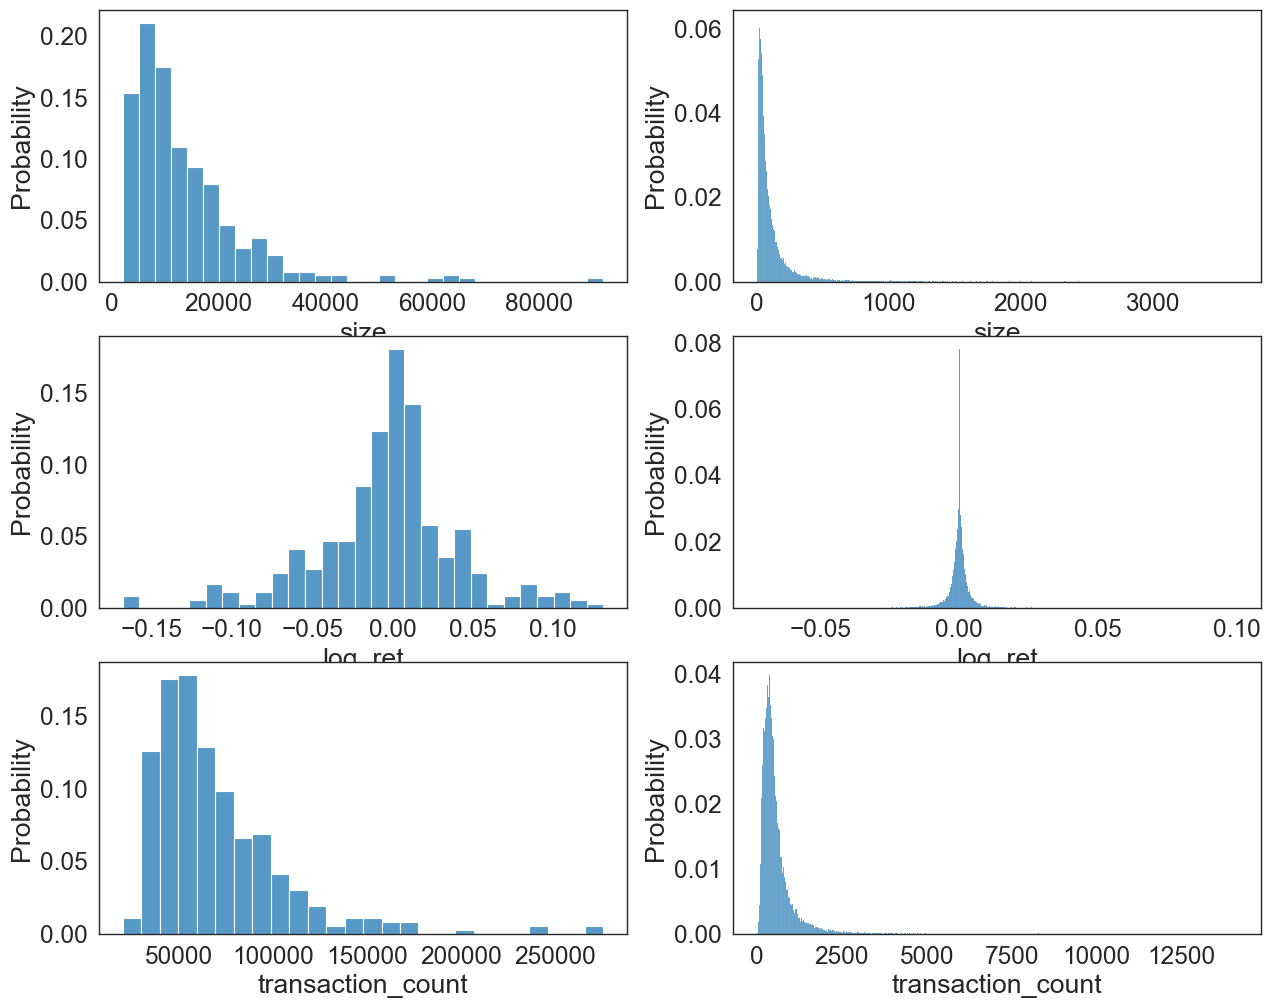

In [106]:
time_dimensions_daily = ['year', 'week','day']
time_dimensions_min = ['year', 'week','day','hour','minute']

getyear(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getweek(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getday(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
gethour(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getminute(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))

# create df for daily
data_hist_daily = pd.DataFrame(dataset.groupby(by=time_dimensions_daily, axis = 0)[measures].sum().reset_index())

# create df for 5-minute intervals
data_hist_min = pd.DataFrame(dataset.groupby(by=time_dimensions_min, axis = 0)[measures].sum().reset_index())
data_hist_min['bin'] = data_hist_min.minute//12
data_hist_5min = pd.DataFrame(data_hist_min.groupby(by=time_dimensions_min[:4] + ['bin'], axis = 0)[measures].sum().reset_index())

# create subplots (daily)
fig, axes = plt.subplots(3,2, figsize=(15,12))

# create chart for daily in each subplot
sns.histplot(data = data_hist_daily, x = 'size', ax=axes[0,0], stat = 'probability')
sns.histplot(data = data_hist_daily, x = 'log_ret', ax=axes[1,0], stat = 'probability')
sns.histplot(data = data_hist_daily, x = 'transaction_count', ax=axes[2,0], stat = 'probability')

# create chart for 5min in each subplot
sns.histplot(data = data_hist_5min, x = 'size', ax=axes[0,1], stat = 'probability')
sns.histplot(data = data_hist_5min, x = 'log_ret', ax=axes[1,1], stat = 'probability')
sns.histplot(data = data_hist_5min, x = 'transaction_count', ax=axes[2,1], stat = 'probability')


In [114]:
print("JB-test statistic for daily returns:" , st.jarque_bera(data_hist_daily.log_ret))
print("JB-test statistic for 5min returns:" , st.jarque_bera(data_hist_5min.log_ret))

JB-test statistic for daily returns: Jarque_beraResult(statistic=55.5414133414287, pvalue=8.696376951888851e-13)
JB-test statistic for 5min returns: Jarque_beraResult(statistic=1699586.985600675, pvalue=0.0)


### Correlations

In [150]:
measures =['log_ret', 'transaction_count', 'size']
print("Pearson correlation for actual trade measures:\n")
print(dataset[measures].corr())
print("\nPearson correlation for consolidated 5min measures:\n")
print(data_hist_5min[measures].corr())
print("\nPearson correlation for consolidated daily measures:\n")
print(data_hist_daily[measures].corr())


Pearson correlation for actual trade measures:

                    log_ret  transaction_count      size
log_ret            1.000000                NaN -0.003734
transaction_count       NaN                NaN       NaN
size              -0.003734                NaN  1.000000

Pearson correlation for consolidated 5min measures:

                    log_ret  transaction_count      size
log_ret            1.000000          -0.017504 -0.004083
transaction_count -0.017504           1.000000  0.813946
size              -0.004083           0.813946  1.000000

Pearson correlation for consolidated daily measures:

                    log_ret  transaction_count      size
log_ret            1.000000          -0.134501 -0.153743
transaction_count -0.134501           1.000000  0.851875
size              -0.153743           0.851875  1.000000


#### Scatter Plots

Scatter-plot for consolidated measures over 5min vs daily:



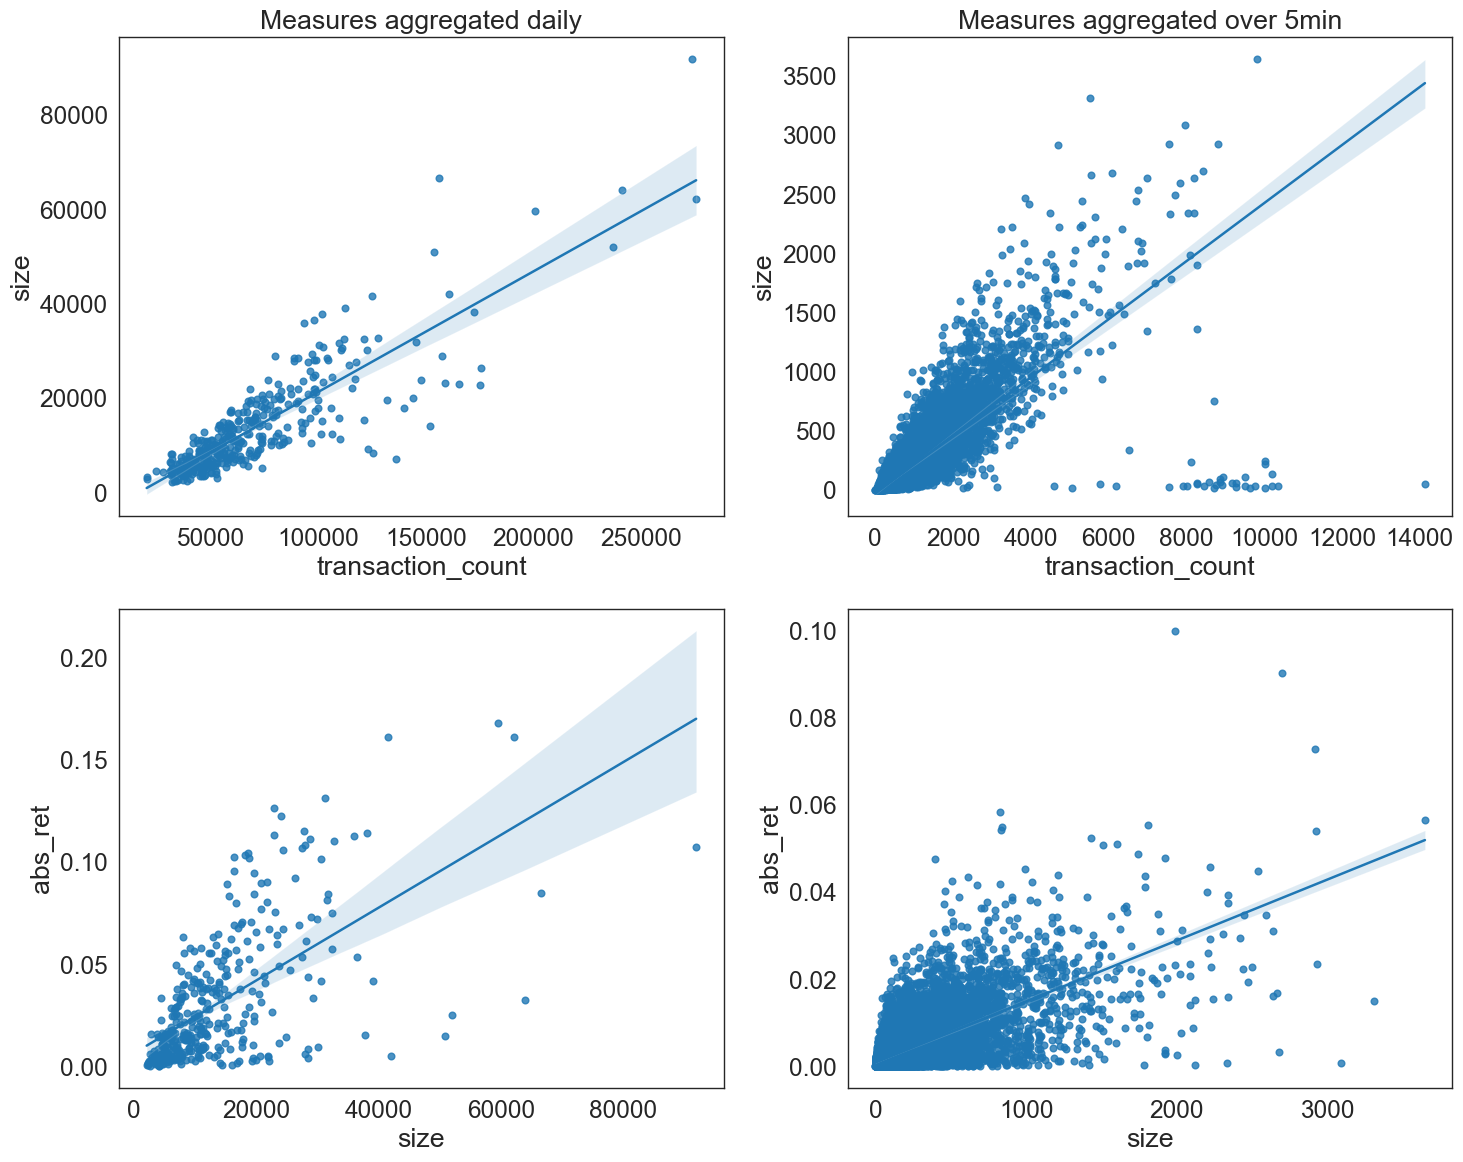

In [162]:
time_dimensions_daily = ['year', 'week','day']
time_dimensions_min = ['year', 'week','day','hour','minute']

getyear(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getweek(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getday(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
gethour(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getminute(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))

# create df for daily
data_hist_daily = pd.DataFrame(dataset.groupby(by=time_dimensions_daily, axis = 0)[measures].sum().reset_index())

# create df for 5-minute intervals
data_hist_min = pd.DataFrame(dataset.groupby(by=time_dimensions_min, axis = 0)[measures].sum().reset_index())
data_hist_min['bin'] = data_hist_min.minute//12
data_hist_5min = pd.DataFrame(data_hist_min.groupby(by=time_dimensions_min[:4] + ['bin'], axis = 0)[measures].sum().reset_index())

# Calculate absolute returns
data_hist_5min['abs_ret']= np.abs(data_hist_5min.log_ret)
data_hist_daily['abs_ret']= np.abs(data_hist_daily.log_ret)

print("Scatter-plot for consolidated measures over 5min vs daily:\n")

# create subplots (daily)
fig, axes = plt.subplots(2,2, figsize=(15,12))
axes[0,1].set_title('Measures aggregated over 5min')
axes[0,0].set_title('Measures aggregated daily')
sns.regplot(data = data_hist_daily, x = 'transaction_count', y = 'size', ax = axes[0,0])
sns.regplot(data = data_hist_5min, x = 'transaction_count', y = 'size', ax = axes[0,1])

sns.regplot(data = data_hist_daily, x = 'size', y = 'abs_ret', ax = axes[1,0])
sns.regplot(data = data_hist_5min, x = 'size', y = 'abs_ret', ax = axes[1,1])

fig.tight_layout()


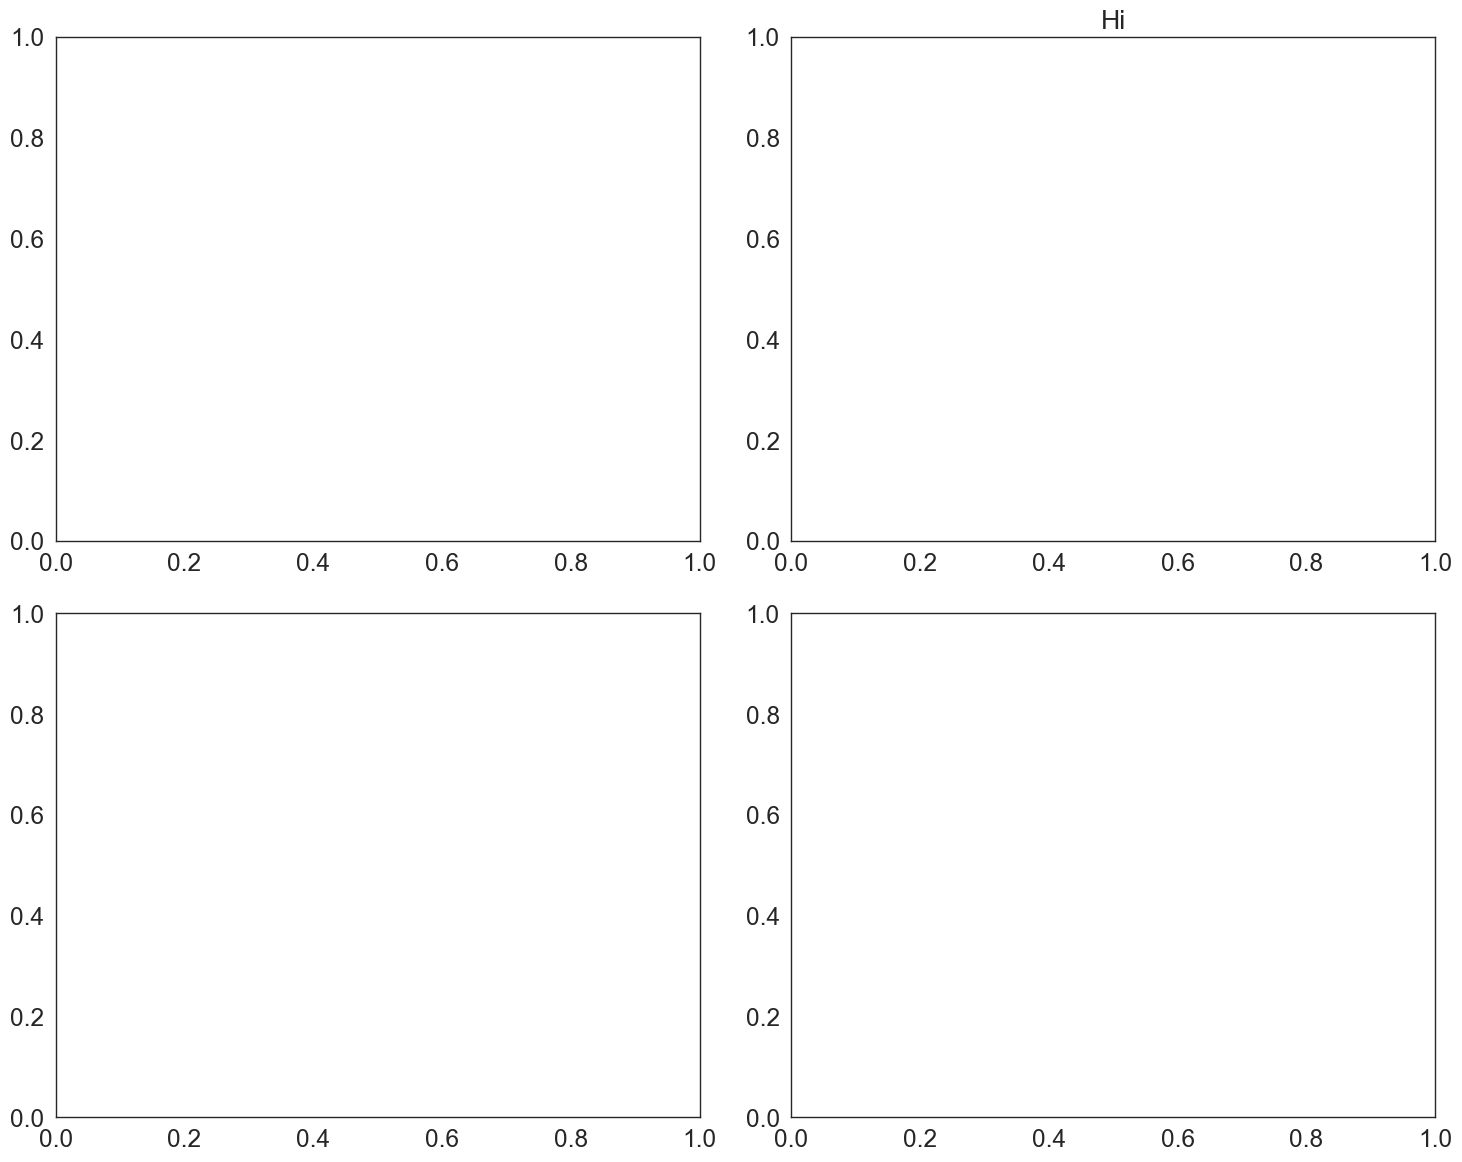

In [161]:
# create subplots (daily)
fig, axes = plt.subplots(2,2, figsize=(15,12))
axes[0,1].set_title('Hi')
fig.tight_layout()

In [125]:
data_hist_5min

,year,week,day,hour,bin,size,log_ret,transaction_count,abs_ret
0,2018,1,1,0,0.0,277.666203,-0.007980,1774,0.007980
1,2018,1,1,0,1.0,160.339027,-0.006577,1125,0.006577
2,2018,1,1,0,2.0,130.621214,0.002719,813,0.002719
3,2018,1,1,0,3.0,141.312548,-0.000075,847,0.000075
4,2018,1,1,0,4.0,265.397889,-0.008212,1351,0.008212
...,...,...,...,...,...,...,...,...,...
43668,2019,1,31,23,0.0,222.345918,0.005255,572,0.005255
43669,2019,1,31,23,1.0,79.897270,-0.001126,428,0.001126
43670,2019,1,31,23,2.0,188.673870,-0.002139,738,0.002139
43671,2019,1,31,23,3.0,49.458250,0.000250,400,0.000250


### Trends of key metrics within certain time frames (hour, minute, second, millisecond)

In [8]:
# Some general variables
measures = ['size','log_ret', 'transaction_count']

# Folders
# Folder specifically for relative time frequencies over intervals
try: os.mkdir(path_to_graphics + "Trends in periodic time intervals")
except (FileExistsError): next
path_to_store = path_to_graphics + "Trends in periodic time intervals/"

In [9]:
# Basis Dataset

# measures at interest
dataset['transaction_count']=1
dataset['log_ret']=np.log(1+dataset['price'].pct_change())

#### Trends within weekday of the week

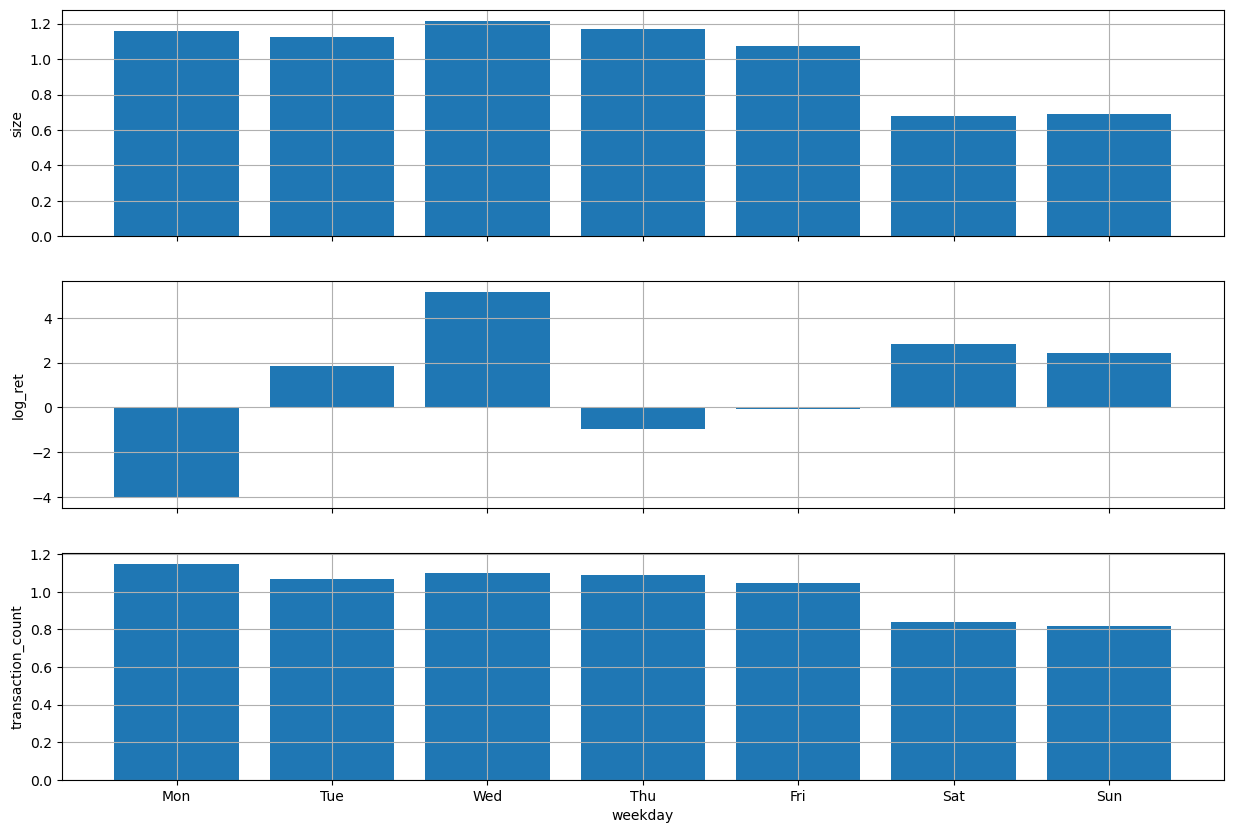

In [274]:
time_dimensions = ['year', 'week','day','weekday']

getyear(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getweek(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getweekday(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getday(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))

# create relative 
data_weekday = pd.DataFrame(dataset.groupby(by=time_dimensions, axis = 0)[measures].sum().reset_index())
plot_measures = []
for j in measures:
    data_weekday[j+'_sum_week'] = data_weekday.groupby(by=time_dimensions[:2], axis = 0)[j].transform('sum')
    data_weekday[j+'_relative'] = 7*data_weekday[j] / data_weekday[j+'_sum_week']
    #data_weekday[j+'_relative_std'] = data_weekday.groupby(by = time_dimensions[3])[j+'_relative'].transform('std')
    plot_measures = plot_measures + [j+'_relative',j+'_relative_std']

# Consolidating on weekdays
data_weekday_plot = pd.DataFrame(data_weekday.groupby(by = time_dimensions[-1])[plot_measures].mean())

# Calculation of deviation from uniform distribution
#for i in measures:
#    data_weekday_plot[i+'_relative'] = data_weekday_plot[i+'_relative'] - (1/7)

#Figure
plots = []
for i in measures:
    plots = plots + [str('plot_'+i)]
fig, (plots) = plt.subplots(len(plots), sharex = True, figsize=(15, 10))
plt.xticks(np.arange(7),["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
plt.xlabel("weekday")
plt.ylabel('rel deviation from uniform distribution')


# Plot Content - Automated
for i in range(len(measures)):
    plots[i].bar(data_weekday_plot.index, data_weekday_plot[measures[i]+'_relative'])
    plots[i].set(ylabel = measures[i])
    plots[i].grid(True)
    #plots[i].fill_between(df.index,df[str('underline_'+measures[i])], df[str('overline_'+measures[i])], color='red', alpha=.3)

# Plot Content - Unique
# Show and Save as Output
plt.savefig(path_to_store + "Trend over weekdays.png", bbox_inches = 'tight')

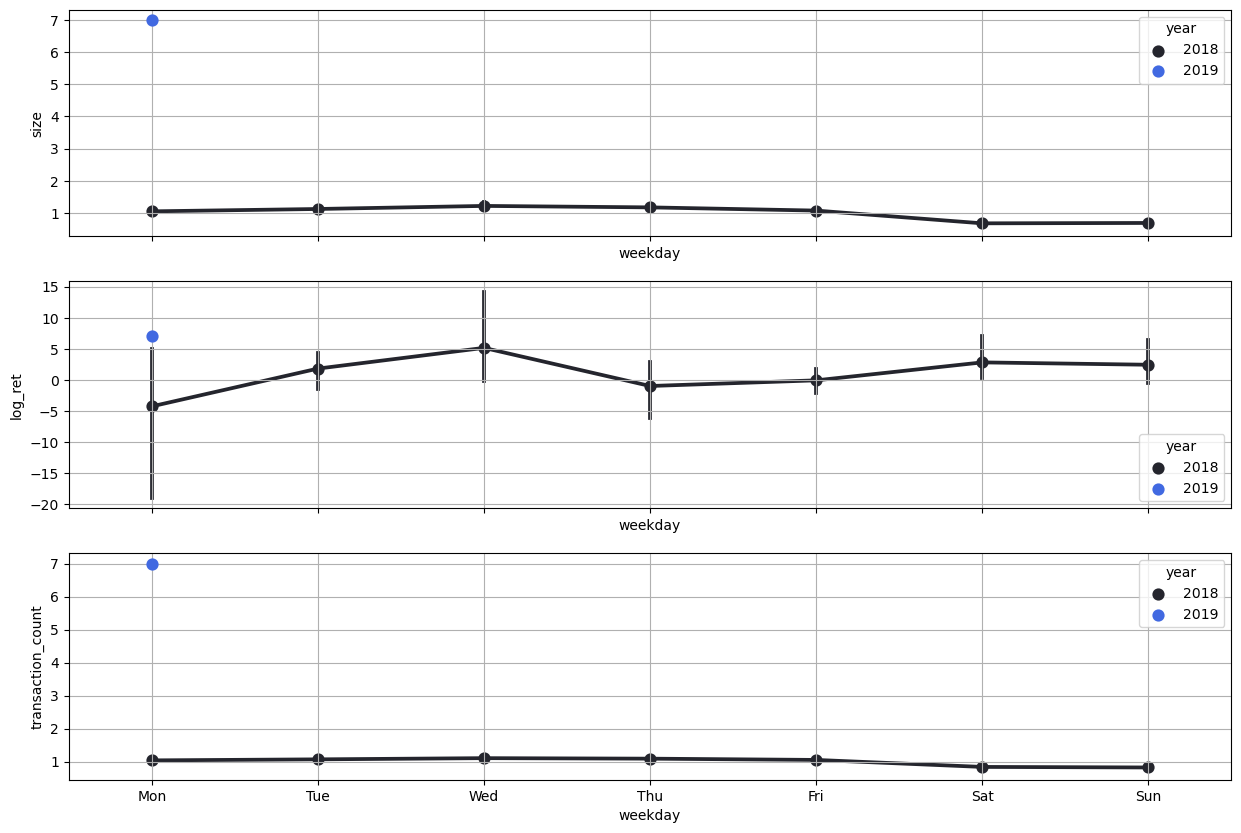

In [19]:
time_dimensions = ['year','week','day','weekday']

getyear(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getweek(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getweekday(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getday(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))

# create relative 
data_weekday = pd.DataFrame(dataset.groupby(by=time_dimensions, axis = 0)[measures].sum().reset_index())
plot_measures = []
for j in measures:
    data_weekday[j+'_sum_week'] = data_weekday.groupby(by=time_dimensions[:2], axis = 0)[j].transform('sum')
    data_weekday[j+'_relative'] = 7*data_weekday[j] / data_weekday[j+'_sum_week']
    plot_measures = plot_measures + [j+'_relative']

#Figure
plots = []
for i in measures:
    plots = plots + [str('plot_'+i)]
fig, (plots) = plt.subplots(len(plots), sharex = True, figsize=(15, 10))
plt.xlabel("weekday")
plt.ylabel('rel deviation from uniform distribution')

# Plot Content - Automated
for i in range(len(measures)):
    if i != 0:
        sns.pointplot(data = data_weekday, x='weekday', y =measures[i]+'_relative', hue = 'year', ax = plots[i], legend = False)
    else: 
        sns.pointplot(data = data_weekday, x='weekday', y =measures[i]+'_relative', hue = 'year', ax = plots[i])
    
    plots[i].set(ylabel = measures[i], )
    plots[i].grid(True)

plt.xticks(np.arange(7),["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])

# Show and Save as Output
plt.savefig(path_to_store + "Trend over weekdays.png", bbox_inches = 'tight')

#### Trends within hours of a day

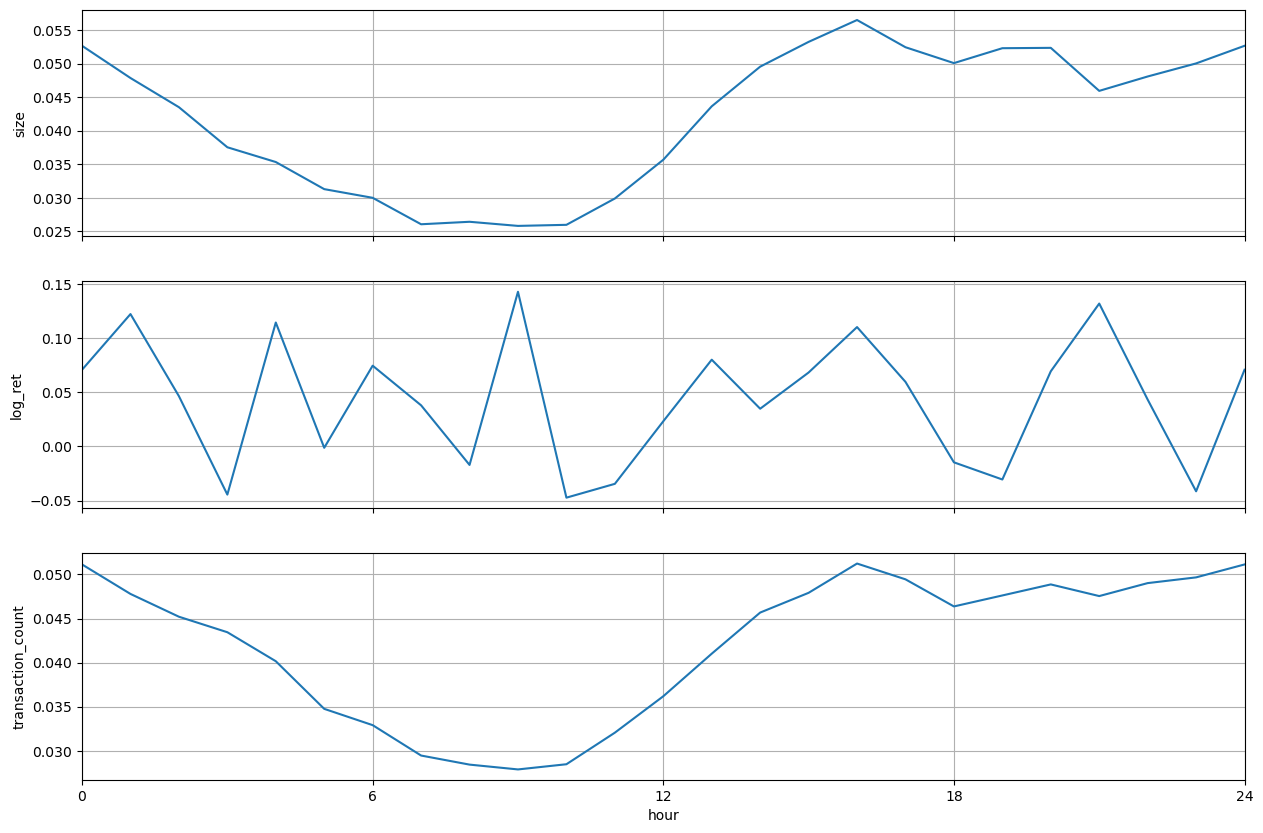

In [20]:
time_dimensions = ['year', 'week','weekday','day','hour']

getyear(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getweek(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getday(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
gethour(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))


# create relative 
data_day = pd.DataFrame(dataset.groupby(by=time_dimensions, axis = 0)[measures].sum().reset_index())
plot_measures = []
for j in measures:
    data_day[j+'_sum_week'] = data_day.groupby(by=time_dimensions[:3], axis = 0)[j].transform('sum')
    data_day[j+'_relative'] = data_day[j] / data_day[j+'_sum_week']
    data_day[j+'_relative_std'] = data_day.groupby(by = time_dimensions[3])[j+'_relative'].transform('std')
    plot_measures = plot_measures + [j+'_relative',j+'_relative_std']

# Consolidating on hours
data_day_plot = pd.DataFrame(data_day.groupby(by = time_dimensions[-1])[plot_measures].mean())
# Calculation of deviation from uniform distribution
#for i in measures:
#    data_day_plot[i+'_relative'] = data_day_plot[i+'_relative'] - (1/24)

# Move last tail entry to the beginnning to allow for holistic plot
data_day_plot = pd.concat([data_day_plot,data_day_plot.head(1)]).reset_index()

#Figure
plots = []
for i in measures:
    plots = plots + [str('plot_'+i)]
fig, (plots) = plt.subplots(len(plots), sharex = True, figsize=(15, 10))
plt.xticks(np.arange(0,24.001,6),['0','6','12','18','24'])
plt.xlabel("hour")
plt.ylabel('rel measure (divided by daily sum)')
plt.xlim(0,24)


# Plot Content - Automated
for i in range(len(measures)):
    plots[i].plot(data_day_plot[measures[i]+'_relative'])
    plots[i].set(ylabel = measures[i])
    plots[i].grid(True)
    #plots[i].fill_between(df.index,df[str('underline_'+measures[i])], df[str('overline_'+measures[i])], color='red', alpha=.3)

# Plot Content - Unique
# Show and Save as Output
plt.savefig(path_to_store + "Trend over day.png", bbox_inches = 'tight')

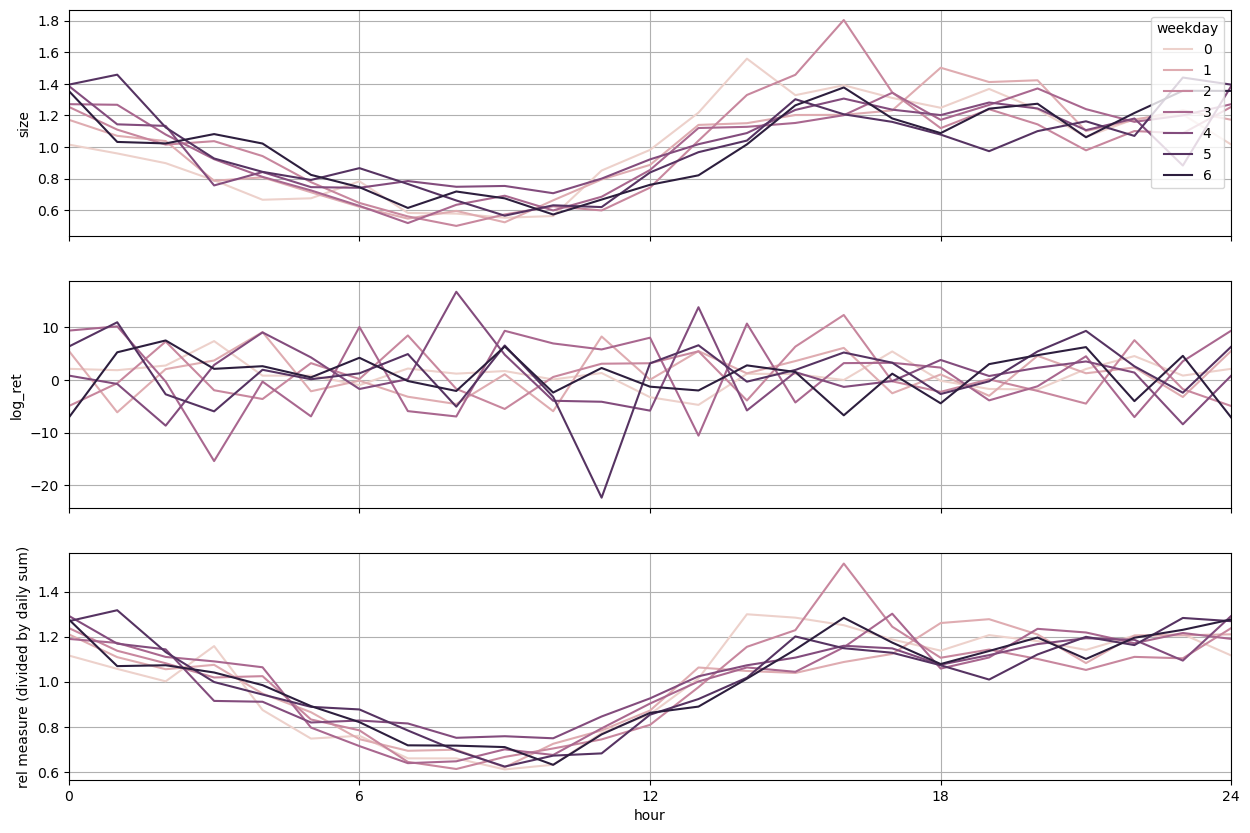

In [45]:
time_dimensions = ['year', 'week','weekday','day','hour']

getyear(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getweek(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getweekday(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getday(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
gethour(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))


# create relative 
data_day = pd.DataFrame(dataset.groupby(by=time_dimensions, axis = 0)[measures].sum().reset_index())
plot_measures = []
for j in measures:
    data_day[j+'_sum_week'] = data_day.groupby(by=time_dimensions[:3], axis = 0)[j].transform('sum')
    data_day[j+'_relative'] = 24 * data_day[j] / data_day[j+'_sum_week']
    plot_measures = plot_measures + [j+'_relative']

# Add 24th hour to dataset, that is equal to hour 0 to adjust plot
data_day_help = data_day[data_day['hour']== 0].reset_index()
data_day_help['hour']=24
data_day = pd.concat([data_day, data_day_help], ignore_index=True)

#Figure
plots = []
for i in measures:
    plots = plots + [str('plot_'+i)]
fig, (plots) = plt.subplots(len(plots), sharex = True, figsize=(15, 10))

# Plot Content - Automated
for i in range(len(measures)):
    if i != 0:
        sns.lineplot(data = data_day, x='hour', y=measures[i]+'_relative', hue='weekday', ax = plots[i], ci=None, legend = False)
    else: 
        sns.lineplot(data = data_day, x='hour', y=measures[i]+'_relative', hue='weekday', ax = plots[i], ci=None)
    plots[i].set(ylabel = measures[i])
    plots[i].grid(True)

# Plot Format
plt.xticks(np.arange(0,24.001,6),['0','6','12','18','24'])
plt.xlabel("hour")
plt.ylabel('rel measure (divided by daily sum)')
plt.xlim(0,24)

# Show and Save as Output
plt.savefig(path_to_store + "Trend over day.png", bbox_inches = 'tight')

#### Trends within minutes of a hour

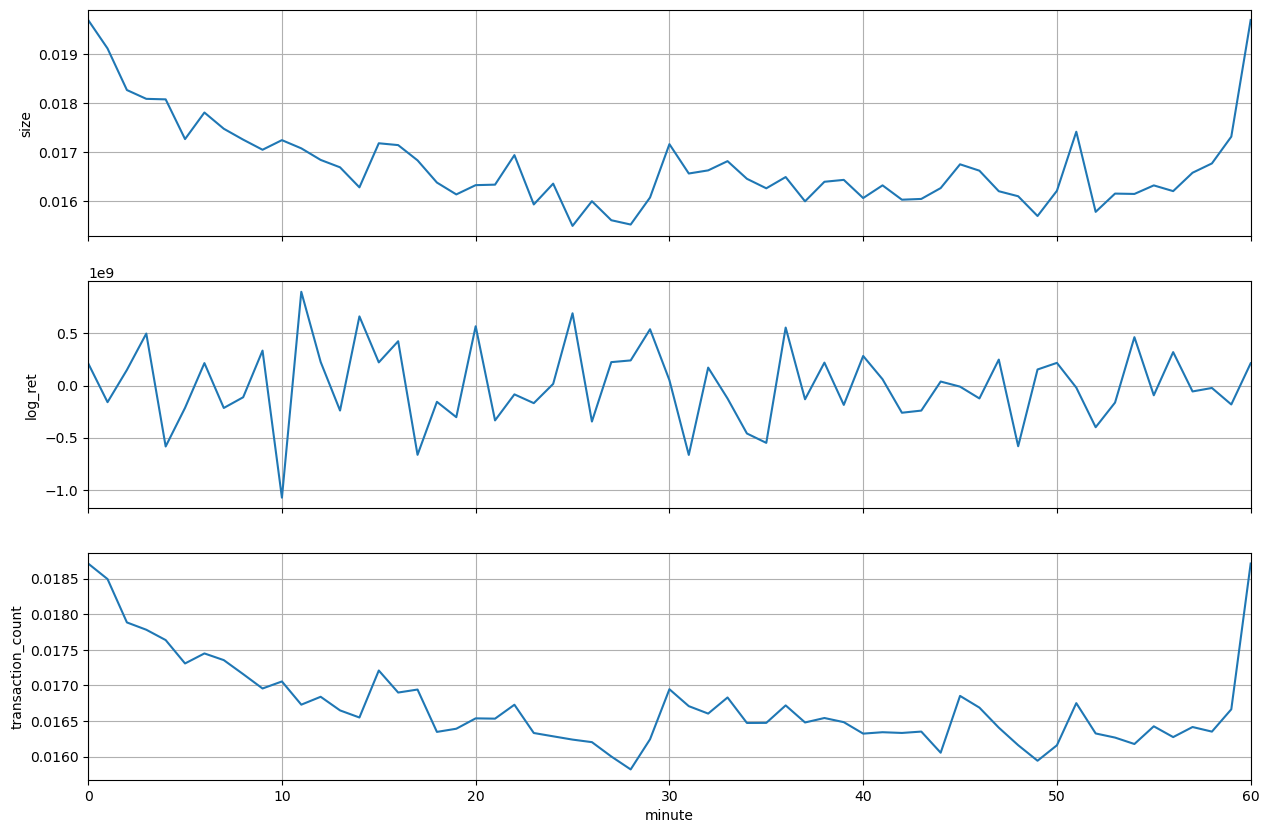

In [301]:
time_dimensions = ['year', 'week','day','hour','minute']

getyear(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getweek(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getday(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
gethour(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getminute(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))


# create relative 
data_hour = pd.DataFrame(dataset.groupby(by=time_dimensions, axis = 0)[measures].sum().reset_index())
plot_measures = []
for j in measures:
    data_hour[j+'_sum_hour'] = data_hour.groupby(by=time_dimensions[:4], axis = 0)[j].transform('sum')
    data_hour[j+'_relative'] = data_hour[j] / data_hour[j+'_sum_hour']
    plot_measures = plot_measures + [j+'_relative']
    

#Figure
plots = []
for i in measures:
    plots = plots + [str('plot_'+i)]
fig, (plots) = plt.subplots(len(plots), sharex = True, figsize=(15, 10))



# Plot Content - Unbinned
for i in range(len(measures)):
    plots[i].plot(data_hour_plot[measures[i]+'_relative'])
    plots[i].set(ylabel = measures[i])
    plots[i].grid(True)
    #plots[i].fill_between(df.index,df[str('underline_'+measures[i])], df[str('overline_'+measures[i])], color='red', alpha=.3)

# Plot Format
plt.xticks(np.arange(0,60.001,10),['0','10','20','30','40','50','60'])
plt.xlabel("minute")
plt.ylabel('rel measure (divided by hourly sum)')
plt.xlim(0,60)
# Show and Save as Output
plt.savefig(path_to_store + "Trend over hour.png", bbox_inches = 'tight')

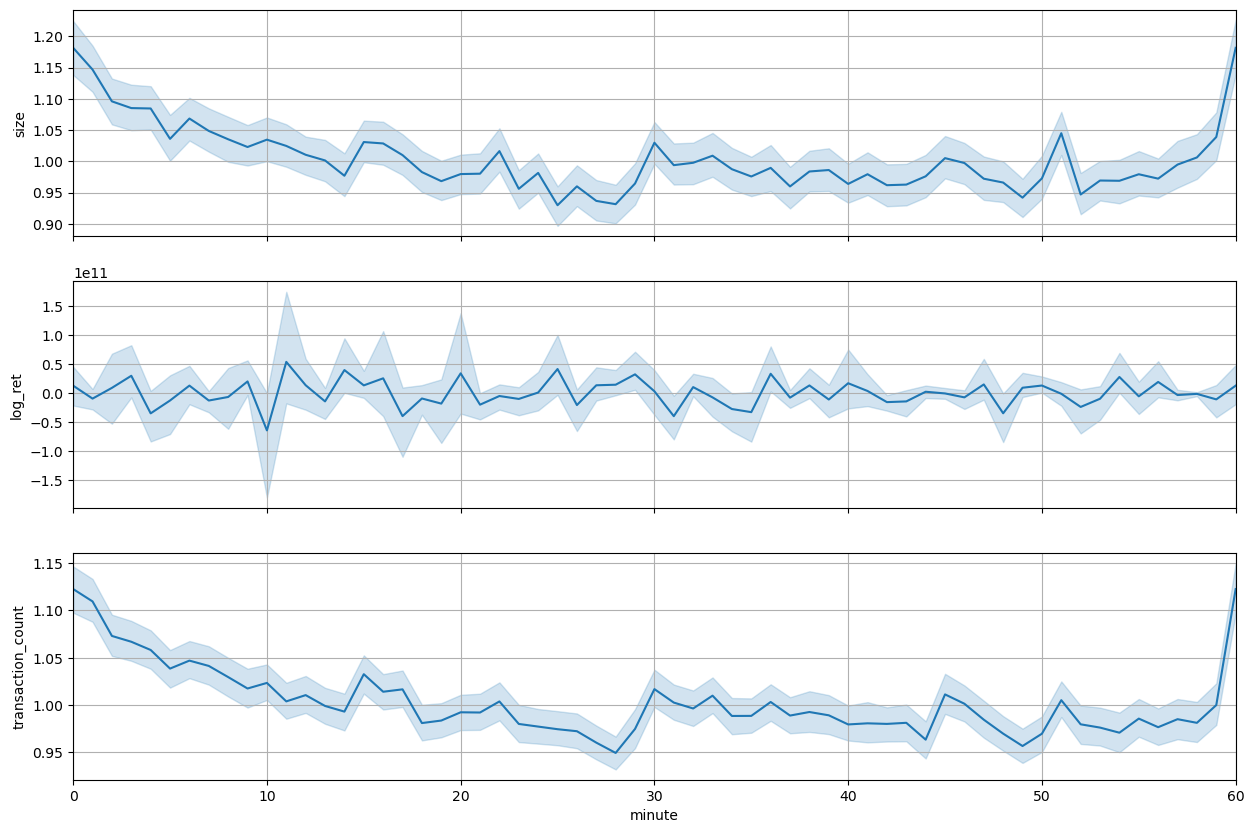

In [49]:
time_dimensions = ['year', 'week','day','hour','minute']

getyear(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getweek(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getday(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
gethour(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getminute(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))


# create relative 
data_hour = pd.DataFrame(dataset.groupby(by=time_dimensions, axis = 0)[measures].sum().reset_index())
plot_measures = []
for j in measures:
    data_hour[j+'_sum_hour'] = data_hour.groupby(by=time_dimensions[:4], axis = 0)[j].transform('sum')
    data_hour[j+'_relative'] = 60* data_hour[j] / data_hour[j+'_sum_hour']
    plot_measures = plot_measures + [j+'_relative']

# Add 24th hour to dataset, that is equal to hour 0 to adjust plot
data_hour_help = data_hour[data_hour['minute']== 0].reset_index()
data_hour_help['minute']=60
data_hour = pd.concat([data_hour, data_hour_help], ignore_index=True)

#Figure
plots = []
for i in measures:
    plots = plots + [str('plot_'+i)]
fig, (plots) = plt.subplots(len(plots), sharex = True, figsize=(15, 10))

# Plot Content - Automated
for i in range(len(measures)):
    if i != 0:
        sns.lineplot(data = data_hour, x='minute', y=measures[i]+'_relative', ax = plots[i], legend = False)
    else: 
        sns.lineplot(data = data_hour, x='minute', y=measures[i]+'_relative', ax = plots[i])
    plots[i].set(ylabel = measures[i])
    plots[i].grid(True)

# Plot Format
plt.xticks(np.arange(0,60.001,10),['0','10','20','30','40','50','60'])
plt.xlabel("minute")
plt.xlim(0,60)
# Show and Save as Output
plt.savefig(path_to_store + "Trend over hour.png", bbox_inches = 'tight')

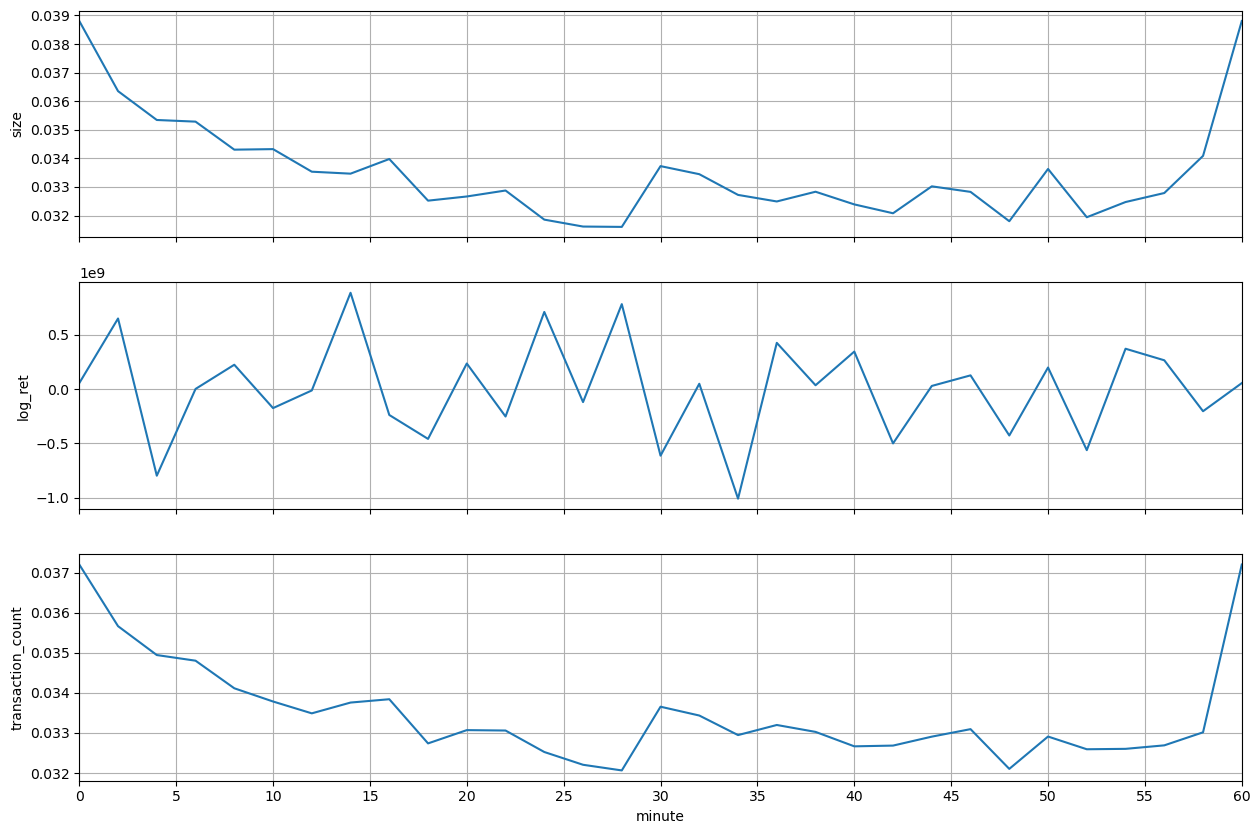

In [308]:
# Plot Content - Binned
bin_size = 2
tick_size = 5
# Group data by bins
data_hour_plot['bin'] = data_hour_plot.index // bin_size
plot_measures_bin = []
for i in measures:
    data_hour_plot[i +'_relative_bin'] = data_hour_plot.groupby(by = 'bin')[i+'_relative'].transform('sum')
    plot_measures_bin = plot_measures_bin + [i+'_relative_bin']
    
#Consolidate on bins
data_hour_plot_bin = pd.DataFrame(data_hour_plot.head(60).groupby(by= 'bin')[plot_measures_bin].mean()).reset_index()
# Move last tail entry to the beginnning to allow for holistic plot
data_hour_plot_bin = pd.concat([data_hour_plot_bin,data_hour_plot_bin.head(1)]).reset_index()

#Figure
plots = []
for i in measures:
    plots = plots + [str('plot_'+i)]
fig, (plots) = plt.subplots(len(plots), sharex = True, figsize=(15, 10))
plt.xticks(np.arange(0,(60+0.01)/bin_size,tick_size/bin_size),['0','5','10','15','20','25','30','35','40','45','50','55','60'])
plt.xlabel("minute")
plt.ylabel('rel measure (divided by hourly sum)')
plt.xlim(0,60/bin_size)

for i in range(len(measures)):
    plots[i].plot(data_hour_plot_bin[measures[i]+'_relative_bin'])
    plots[i].set(ylabel = measures[i])
    plots[i].grid(True)
    #plots[i].fill_between(df.index,df[str('underline_'+measures[i])], df[str('overline_'+measures[i])], color='red', alpha=.3)

#### Trends within seconds of a minute

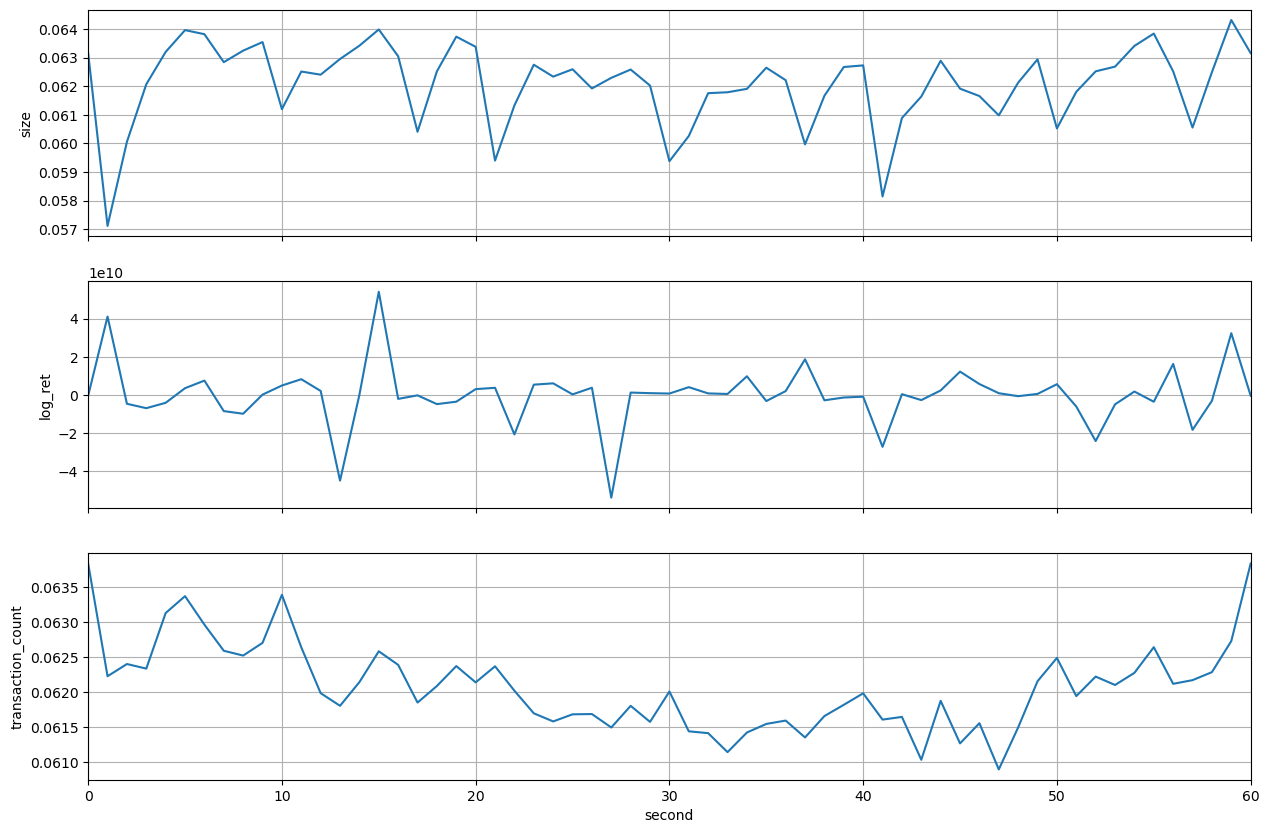

In [310]:
time_dimensions = ['year', 'week','day','hour','minute','second']

getyear(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getweek(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getday(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
gethour(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getminute(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getsecond(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))


# create relative 
data_minute = pd.DataFrame(dataset.groupby(by=time_dimensions, axis = 0)[measures].sum().reset_index())
plot_measures = []
for j in measures:
    data_minute[j+'_sum_minute'] = data_minute.groupby(by=time_dimensions[:5], axis = 0)[j].transform('sum')
    data_minute[j+'_relative'] = data_minute[j] / data_minute[j+'_sum_minute']
    data_minute[j+'_relative_std'] = data_minute.groupby(by = time_dimensions[5])[j+'_relative'].transform('std')
    plot_measures = plot_measures + [j+'_relative',j+'_relative_std']
    
# Consolidating on seconds
data_minute_plot = pd.DataFrame(data_minute.groupby(by = time_dimensions[-1])[plot_measures].mean())
# Calculation of deviation from uniform distribution
#for i in measures:
#    data_day_plot[i+'_relative'] = data_day_plot[i+'_relative'] - (1/24)

# Move last tail entry to the beginnning to allow for holistic plot
data_minute_plot = pd.concat([data_minute_plot,data_minute_plot.head(1)]).reset_index()

#Figure
plots = []
for i in measures:
    plots = plots + [str('plot_'+i)]
fig, (plots) = plt.subplots(len(plots), sharex = True, figsize=(15, 10))
plt.xticks(np.arange(0,60.001,10),['0','10','20','30','40','50','60'])
plt.xlabel("second")
plt.ylabel('rel measure (divided by individual minute sum)')
plt.xlim(0,60)


# Plot Content - Unbinned
for i in range(len(measures)):
    plots[i].plot(data_minute_plot[measures[i]+'_relative'])
    plots[i].set(ylabel = measures[i])
    plots[i].grid(True)
    #plots[i].fill_between(df.index,df[str('underline_'+measures[i])], df[str('overline_'+measures[i])], color='red', alpha=.3)

# Plot Content - Unique
# Show and Save as Output
plt.savefig(path_to_store + "Trend over minute.png", bbox_inches = 'tight')

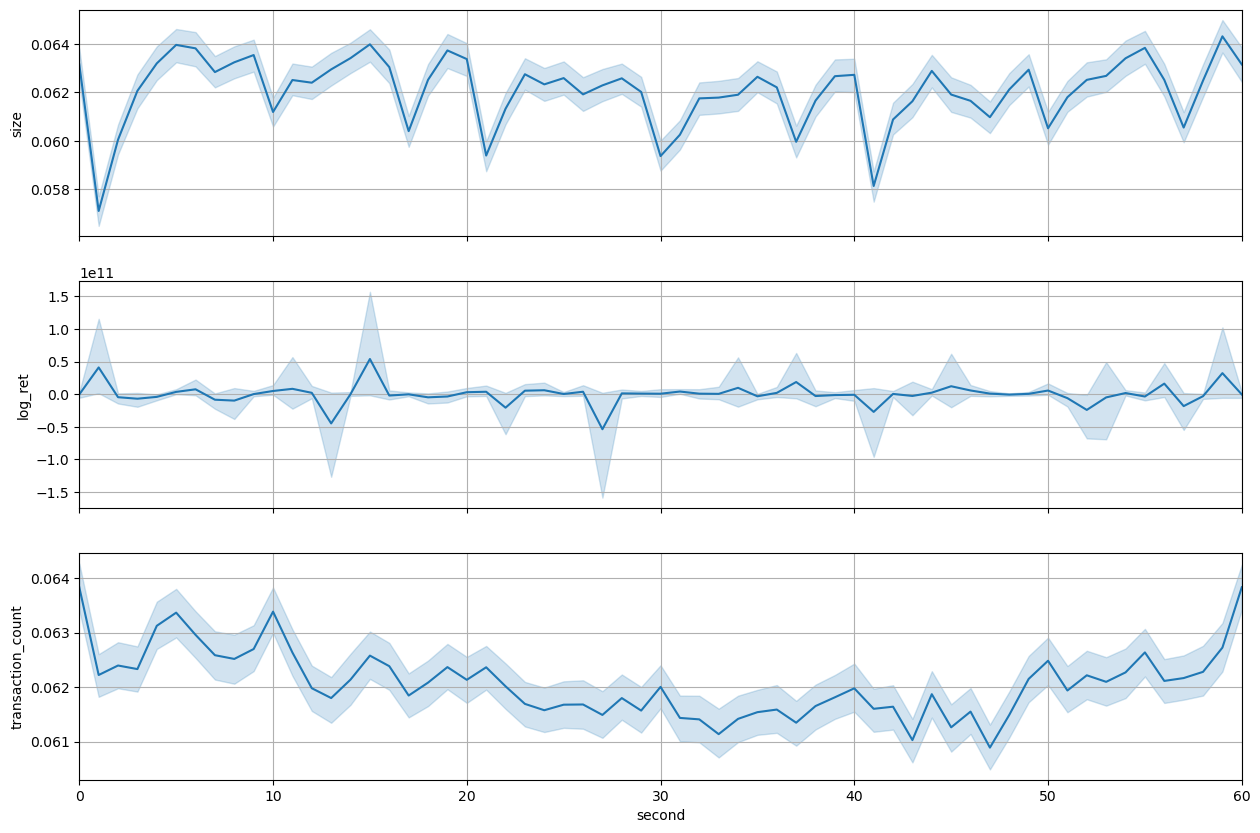

In [51]:
# Plots with seaborn
time_dimensions = ['year', 'week','day','hour','minute','second']

getyear(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getweek(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getday(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
gethour(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getminute(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getsecond(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))


# create relative 
data_minute = pd.DataFrame(dataset.groupby(by=time_dimensions, axis = 0)[measures].sum().reset_index())
plot_measures = []
for j in measures:
    data_minute[j+'_sum_minute'] = data_minute.groupby(by=time_dimensions[:5], axis = 0)[j].transform('sum')
    data_minute[j+'_relative'] = 60 * data_minute[j] / data_minute[j+'_sum_minute']
    plot_measures = plot_measures + [j+'_relative']

# Add 60th second to dataset, that is equal to hour 0 to adjust plot
data_minute_help = data_minute[data_minute['second']== 0].reset_index()
data_minute_help['second']=60
data_minute = pd.concat([data_minute, data_minute_help], ignore_index=True)

#Figure
plots = []
for i in measures:
    plots = plots + [str('plot_'+i)]
fig, (plots) = plt.subplots(len(plots), sharex = True, figsize=(15, 10))

# Plot Content - Automated
for i in range(len(measures)):
    if i != 0:
        sns.lineplot(data = data_minute, x='second', y=measures[i]+'_relative', ax = plots[i], legend = False)
    else: 
        sns.lineplot(data = data_minute, x='second', y=measures[i]+'_relative', ax = plots[i])
    plots[i].set(ylabel = measures[i])
    plots[i].grid(True)


# Plot Format
plt.xticks(np.arange(0,60.001,10),['0','10','20','30','40','50','60'])
plt.xlabel("second")
plt.xlim(0,60)

# Show and Save as Output
plt.savefig(path_to_store + "Trend over minute.png", bbox_inches = 'tight')

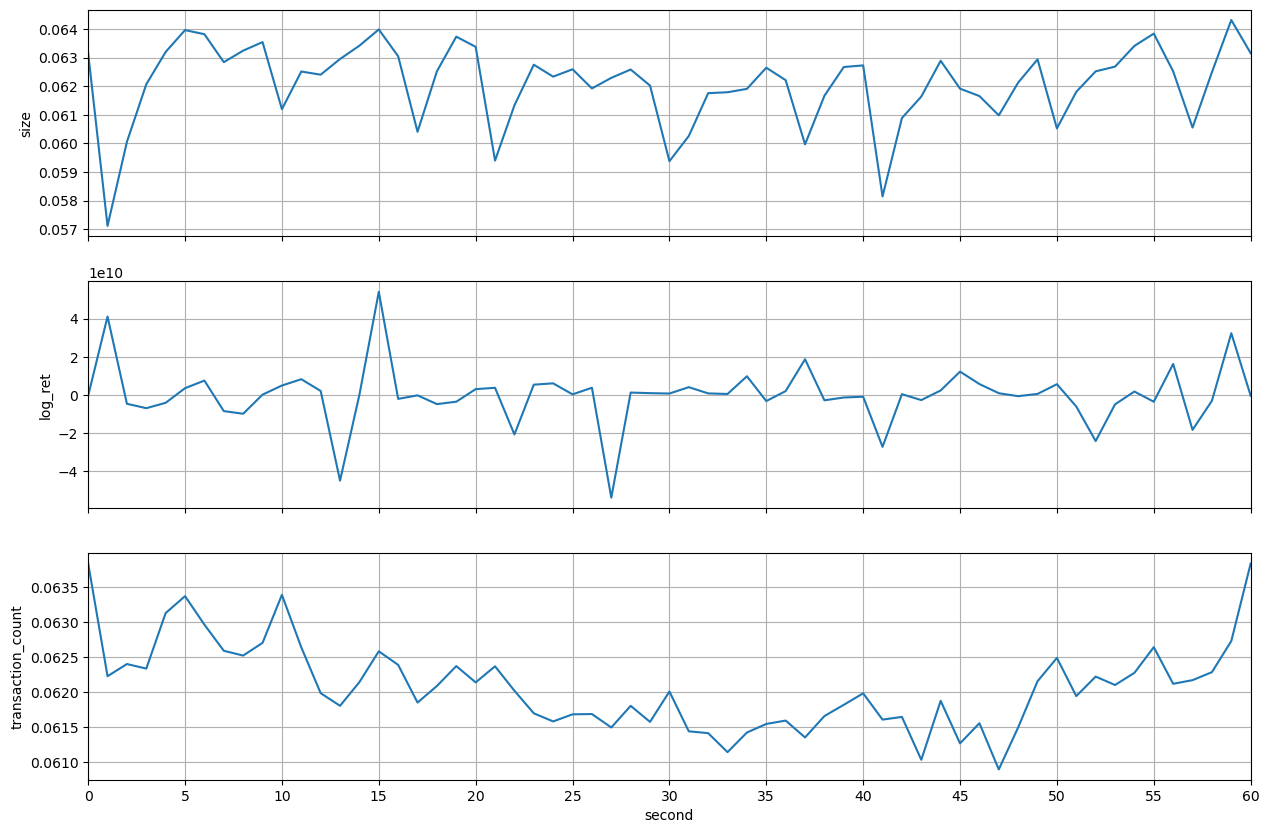

In [312]:
# Plot Content - Binned
bin_size = 1
tick_size = 5
# Group data by bins
data_minute_plot['bin'] = data_minute_plot.index // bin_size
plot_measures_bin = []
for i in measures:
    data_minute_plot[i +'_relative_bin'] = data_minute_plot.groupby(by = 'bin')[i+'_relative'].transform('sum')
    plot_measures_bin = plot_measures_bin + [i+'_relative_bin']
    
#Consolidate on bins
data_minute_plot_bin = pd.DataFrame(data_minute_plot.head(60).groupby(by= 'bin')[plot_measures_bin].mean()).reset_index()
# Move last tail entry to the beginnning to allow for holistic plot
data_minute_plot_bin = pd.concat([data_minute_plot_bin,data_minute_plot_bin.head(1)]).reset_index()

#Figure
plots = []
for i in measures:
    plots = plots + [str('plot_'+i)]
fig, (plots) = plt.subplots(len(plots), sharex = True, figsize=(15, 10))
plt.xticks(np.arange(0,(60+0.01)/bin_size,tick_size/bin_size),['0','5','10','15','20','25','30','35','40','45','50','55','60'])
plt.xlabel("second")
plt.ylabel('rel measure (divided by sum per minute)')
plt.xlim(0,60/bin_size)

for i in range(len(measures)):
    plots[i].plot(data_minute_plot_bin[measures[i]+'_relative_bin'])
    plots[i].set(ylabel = measures[i])
    plots[i].grid(True)
    #plots[i].fill_between(df.index,df[str('underline_'+measures[i])], df[str('overline_'+measures[i])], color='red', alpha=.3)_plot.groupby(by = 'bin')[i+'_relative'].transform('sum')

#### Trends within milliseconds of a second

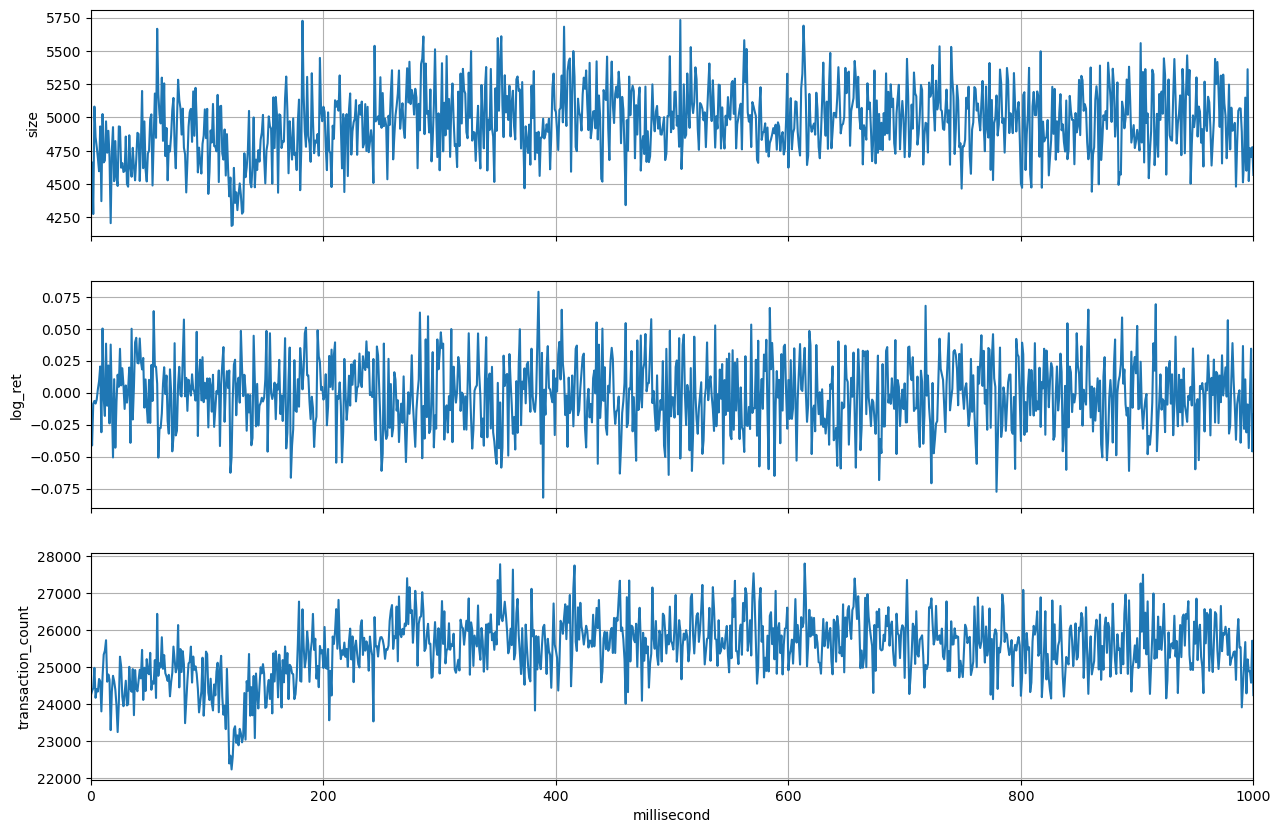

In [27]:
time_dimensions = ['year', 'week','day','hour','minute','second','millisecond']

getyear(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getweek(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getday(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
gethour(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getminute(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getsecond(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getmillisecond(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))

# create relative 
data_second = pd.DataFrame(dataset.groupby(by=time_dimensions, axis = 0)[measures].sum().reset_index())
plot_measures = []
for j in measures:
    data_second[j+'_sum_second'] = data_second.groupby(by=time_dimensions[:6], axis = 0)[j].transform('sum')
    data_second[j+'_relative'] = data_second[j] / data_second[j+'_sum_second']
    data_second[j+'_relative_std'] = data_second.groupby(by = time_dimensions[6])[j+'_relative'].transform('std')
    plot_measures = plot_measures + [j+'_relative',j+'_relative_std']

# Consolidating on seconds
data_second_plot = pd.DataFrame(data_second.groupby(by = time_dimensions[-1])[measures].sum())
# Calculation of deviation from uniform distribution
#for i in measures:
#    data_day_plot[i+'_relative'] = data_day_plot[i+'_relative'] - (1/24)

# Move last tail entry to the beginnning to allow for holistic plot
data_second_plot = pd.concat([data_second_plot,data_second_plot.head(1)]).reset_index()

#Figure
plots = []
for i in measures:
    plots = plots + [str('plot_'+i)]
fig, (plots) = plt.subplots(len(plots), sharex = True, figsize=(15, 10))
#plt.xticks(np.arange(0,60.001,10),['0','10','20','30','40','50','60'])
plt.xlabel("millisecond")
plt.ylabel('rel measure (divided by individual second sum)')
plt.xlim(0,1000)


# Plot Content - Unbinned
for i in range(len(measures)):
    plots[i].plot(data_second_plot[measures[i]])
    plots[i].set(ylabel = measures[i])
    plots[i].grid(True)
    #plots[i].fill_between(df.index,df[str('underline_'+measures[i])], df[str('overline_'+measures[i])], color='red', alpha=.3)

# Plot Content - Unique
# Show and Save as Output
plt.savefig(path_to_store + "Trend over second.png", bbox_inches = 'tight')

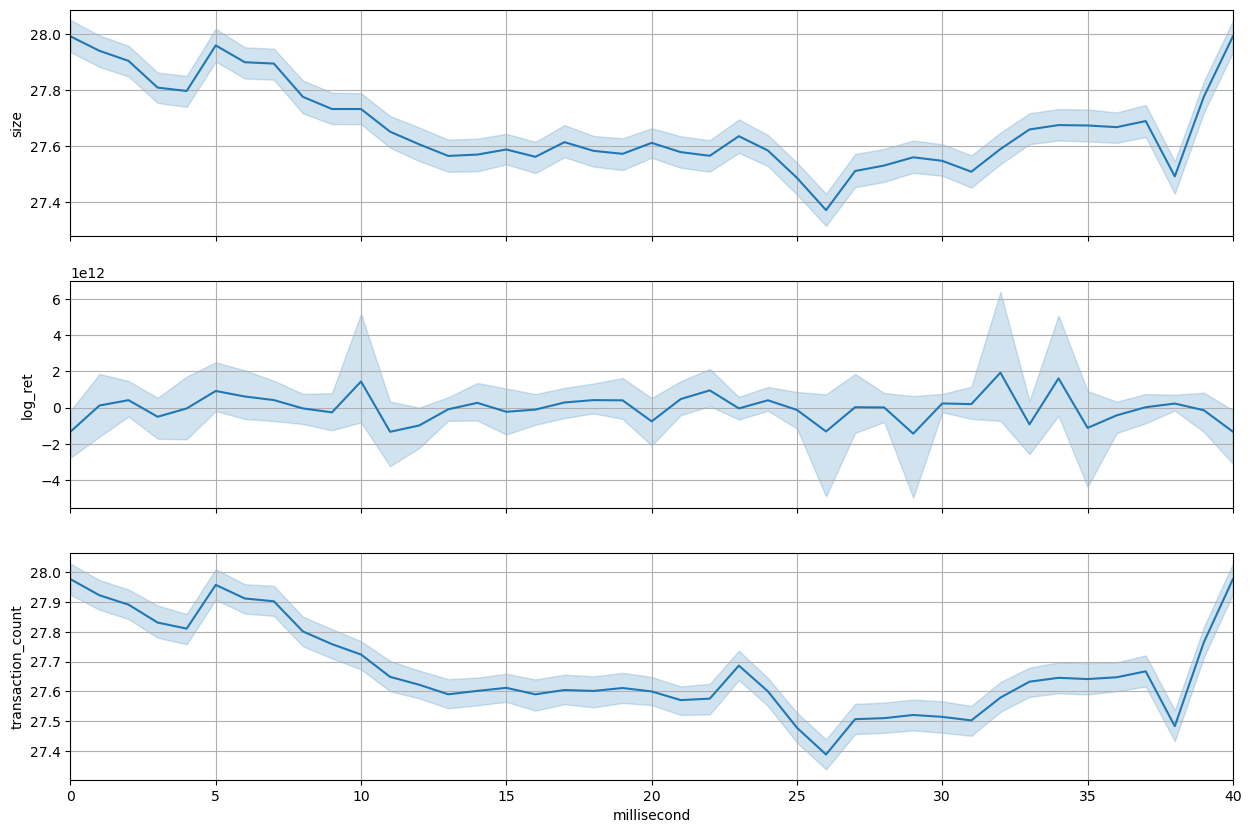

In [75]:
time_dimensions = ['year', 'week','day','hour','minute','second','millisecond']

getyear(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getweek(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getday(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
gethour(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getminute(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getsecond(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getmillisecond(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))

# create relative 
data_second = pd.DataFrame(dataset.groupby(by=time_dimensions, axis = 0)[measures].sum().reset_index())
plot_measures = []
for j in measures:
    data_second[j+'_sum_second'] = data_second.groupby(by=time_dimensions[:6], axis = 0)[j].transform('sum')
    data_second[j+'_relative'] = (1000/bin_size) * data_second[j] / data_second[j+'_sum_second']
    plot_measures = plot_measures + [j+'_relative']

# Create bins
bin_size = 25
data_second['bin']=data_second.millisecond // bin_size

# Add first bin to dataset, that is equal to first bin of next second to adjust plot
data_second_help = data_second[data_second['bin']== 0].reset_index()
data_second_help['bin']=1000//bin_size
data_second = pd.concat([data_second, data_second_help], ignore_index=True)

#Figure
plots = []
for i in measures:
    plots = plots + [str('plot_'+i)]
fig, (plots) = plt.subplots(len(plots), sharex = True, figsize=(15, 10))

# Plot Content - Automated
for i in range(len(measures)):
    if i != 0:
        sns.lineplot(data = data_second, x='bin', y=measures[i]+'_relative', ax = plots[i], legend = False)
    else: 
        sns.lineplot(data = data_second, x='bin', y=measures[i]+'_relative', ax = plots[i])
    plots[i].set(ylabel = measures[i])
    plots[i].grid(True)

# Plot Format
plt.xlabel("millisecond")
#plt.xticks(np.arange(0,40.0001,8),['0','200','400','600','800','1000'])
plt.xlim(0,1000/bin_size)
# Show and Save as Output
plt.savefig(path_to_store + "Trend over second.png", bbox_inches = 'tight')

### (Auto-)correlations

#### for measures by seconds

In [83]:
# Plots with seaborn
time_dimensions = ['year', 'week','day','hour','minute','second']

getyear(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getweek(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getday(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
gethour(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getminute(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))
getsecond(pd.to_datetime(dataset['time_seconds']*1000, unit ='ms'))


# create relative 
data_minute = pd.DataFrame(dataset.groupby(by=time_dimensions, axis = 0)[measures].sum().reset_index()).drop(labels = time_dimensions[:-1], axis = 'columns')

In [ ]:
data_minute

In [ ]:
plt.acorr(data_minute['size'], maxlags = 10)

#### for measures by milliseconds

In [ ]:
for 